In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import joblib
plt.rcParams['figure.figsize'] = 8, 6

- Definimos función que usaremos para extraer las caracteristicas necesarias de una canción para hacer una predicción de probabilidad de ser un *hit*.

In [2]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id='01ec25b32db847e3aeb622ebe1a894c8', client_secret='cd8d3b7666164ea5943688215d9226c2') 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=50)

def find_song():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        track_feat = sp.audio_features(id_track)
        song = [[track_feat[0]["danceability"], track_feat[0]["energy"], track_feat[0]["key"],
        track_feat[0]["loudness"], track_feat[0]["mode"], track_feat[0]["speechiness"],
        track_feat[0]["acousticness"], track_feat[0]["instrumentalness"], track_feat[0]["liveness"],
        track_feat[0]["valence"], track_feat[0]["tempo"],track_feat[0]["time_signature"],
                track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Se lee dataframe y se realiza *split* para los entrenamientos

In [3]:
df_songs = pd.read_csv("../Data/fusion_songs_1958_2020.csv")

In [4]:
df_songs.head()

,artist,title,id,year_chart,date_chart,release_date,collaboration,rank,weeks,isNew,peakPos,lastPos,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,popularity_artist,popularity_song,genres,album,label,song_lyrics,target
0,Hiss Golden Messenger,Lateness of Dancers,42z4npwegunTwhYIjmQdqR,NaN,NaN,2014-09-09,False,NaN,NaN,NaN,NaN,NaN,0.595,0.179,2,-11.783,1,0.0279,0.8480,0.010300,0.5310,0.200,123.533,4,320186,55,27,"['alternative country', 'chamber pop', 'deep n...",Lateness of Dancers,Merge Records,NaN,0
1,Johnny Mathis,My Love for You,5foJJKZXkVdAp5XBYPR5Uw,1960.0,1960-11-07,2015-09-25,False,97.0,11.0,False,47.0,80.0,0.157,0.414,2,-10.966,1,0.0366,0.6810,0.000047,0.1740,0.181,87.920,4,187160,57,30,"['adult standards', 'brill building pop', 'eas...",The Singles,Columbia/Legacy,NaN,1
2,NLE Choppa,Camelot,4sWuPniHClkInYAnzXAYUF,2020.0,2020-02-15,2019-09-13,False,99.0,20.0,False,37.0,92.0,0.787,0.713,7,-5.252,1,0.4010,0.0849,0.000000,0.7170,0.761,175.046,4,148759,84,80,['memphis hip hop'],Camelot,Warner Records,NaN,1
3,Maejor,DeJa Vu,1vJXZIdnyGzEzJ9NedL4s3,NaN,NaN,2017-09-29,True,NaN,NaN,NaN,NaN,NaN,0.806,0.300,8,-10.243,0,0.3220,0.0811,0.000000,0.1120,0.431,137.850,4,183559,54,13,['la pop'],For You - EP,Duke City,NaN,0
4,Play-N-Skillz,"Si Una Vez (feat. Frankie J, Becky G & Kap G) ...",4oagvVIaRqFtwFVeHi9nv9,NaN,NaN,2017-03-31,True,NaN,NaN,NaN,NaN,NaN,0.622,0.812,5,-2.505,1,0.0543,0.0947,0.000027,0.0511,0.410,176.013,4,240193,67,32,"['chicano rap', 'pop rap']","Si Una Vez (feat. Frankie J, Becky G & Kap G) ...",Sony Music Latin/Latium Records,NaN,0


In [5]:
X = df_songs.loc[:,"danceability":"duration_ms"]
y = df_songs.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
df_songs_93 = pd.read_csv("../Data/fusion_songs_1993_2020.csv")

In [27]:
X_93 = df_songs_93.loc[:,"danceability":"duration_ms"]
y_93 = df_songs_93.iloc[:,-1]
X_train_93, X_test_93, y_train_93, y_test_93 = train_test_split(X_93, y_93, random_state=0)

In [28]:
%%time
cross_val_score(forest,X_train_93,y_train_93,cv=5).mean()

Wall time: 10.5 s


0.7608339403223424

In [30]:
forest.fit(X_train_93,y_train_93)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test_93, y_test_93)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train_93, y_train_93)))

Precisión sobre datos de pruebas: 0.7700
Precisión sobre datos de train: 0.9996


In [39]:
import lightgbm as lgb

In [40]:
lgb_clf =lgb.LGBMClassifier()

In [41]:
%%time
cross_val_score(lgb_clf, X_train_93,y_train_93, cv=10).mean()

Wall time: 1.83 s


0.7619977379754881

In [43]:
lgb_clf.fit(X_train_93,y_train_93)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [44]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test_93, y_test_93)))
print("Precisión sobre datos de train: {:.4f}"
      .format(lgb_clf.score(X_train_93, y_train_93)))

Precisión sobre datos de pruebas: 0.7710
Precisión sobre datos de train: 0.8318


## Random Forest

- El primer modelo que usaremos de aprendizaje automatico, será *random forest*

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
forest = RandomForestClassifier ()

In [13]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 29.3 s


0.743318993612306

In [14]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7470
Precisión sobre datos de train: 0.9993


- El numero de estimadores influencia bastante en la rapidez de entremaniento del modelo, ya que indica el numero de arboles usados en el modelo, pero este valor no debe de ser excesivamente alto para obtener un buen *score*. Para ello calcularemos el *score* para diferentes numeros de estimadores, el modelo de *random forest* tendera al sobre entrenamiento, por lo que nos fijaremos en los resultados obtenidos realizando un *cross validation*.

In [33]:
param_range = [30,40,50,60,90,100,130,150,200,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [34]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.7336114732724903 en train: 0.9988200782268579
n_estimators 40 en test: 0.7367405475880051 en train: 0.9992242503259451
n_estimators 50 en test: 0.738200782268579 en train: 0.9994328552803129
n_estimators 60 en test: 0.74 en train: 0.9994915254237288
n_estimators 90 en test: 0.7429465449804433 en train: 0.9995241199478487
n_estimators 100 en test: 0.7429726205997392 en train: 0.9995501955671446
n_estimators 130 en test: 0.7434680573663625 en train: 0.9995501955671446
n_estimators 150 en test: 0.7437548891786181 en train: 0.9995501955671446
n_estimators 200 en test: 0.743155149934811 en train: 0.9995501955671446
n_estimators 300 en test: 0.7446153846153846 en train: 0.9995501955671446


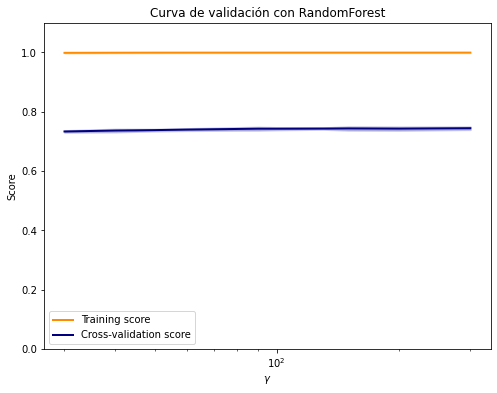

In [35]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Curva de validación con RandomForest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [16]:
forest = RandomForestClassifier (random_state=42)

In [17]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 90)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, None]}


In [18]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [19]:
# Fit the random search model
forest_random.fit(X_train, y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 86.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 103.7min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 127.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 150.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 177.5min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 205.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks    

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [45]:
forest_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_leaf_nodes': None,
 'max_features': 6,
 'max_depth': 20}

In [46]:
forest_random.best_score_

0.7466562377786469

In [47]:
best_forest = forest_random.best_estimator_

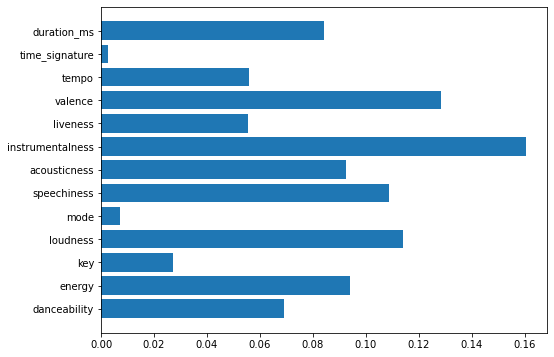

In [48]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_forest.feature_importances_);

In [49]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.2f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7475
Precisión sobre datos de train: 0.95


In [47]:
filename = 'finalized_forest_model_1.pkl'
joblib.dump(best_forest, filename)

['finalized_forest_model_1.pkl']

In [10]:
best_forest = joblib.load('finalized_forest_model_1.pkl') 

In [17]:
best_forest.base_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [51]:
forest_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_leaf_nodes': None,
 'max_features': 6,
 'max_depth': 20}

In [52]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 140, stop = 155, num = 5)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [4,5,6,7,8]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 30, num = 5)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 3, 4, 5]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [2,3, 4]
# Numero maximo de nodos finales
max_leaf_nodes = []
max_leaf_nodes.append(None)
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [140, 143, 147, 151, 155], 'max_features': [4, 5, 6, 7, 8, 'auto'], 'max_depth': [10, 15, 20, 25, 30, None], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4], 'max_leaf_nodes': [None]}


In [53]:
forest_grid = GridSearchCV(estimator = forest, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)

In [54]:
forest_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 84.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 117.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 168.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 204.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 268.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 322.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 402.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 465.4min
[Parallel(n_jobs=-1)]: Done 9097 tasks  

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [55]:
forest_grid.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 151}

In [58]:
forest_grid.best_score_

0.7478555599009257

In [59]:
best_forest_refined = forest_grid.best_estimator_

In [60]:
best_forest_refined.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=151,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_forest_refined.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_forest_refined.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7462
Precisión sobre el juego de train: 0.9317


In [253]:
filename = 'finalized_forest_refined_model.pkl'
joblib.dump(best_forest_refined, filename)

['finalized_forest_refined_model.pkl']

In [21]:
best_forest_refined = joblib.load('finalized_forest_refined_model.pkl') 

In [22]:
best_forest_refined.predict_proba(find_song())

Artista: 

 allie crow buckley


Titulo: 

 hanging tough


array([[0.47930462, 0.52069538]])

## AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostClassifier

In [8]:
ada_clf = AdaBoostClassifier()

In [9]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 6.87 s


0.7121366184330595

In [10]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [11]:
print("Precisión sobre el juego de pruebas: {:.2f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.2f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.71
Precisión sobre el juego de train: 0.72


In [55]:
param_range = [25,30,40,50,60,90,100,130]
train_score, test_score= validation_curve(
                                ada_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [56]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 25 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 30 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 40 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 50 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 60 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 90 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 100 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 130 en test:',test_score[7].mean(),'en train:',train_score[7].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 25 en test: 0.7040417209908736 en train : 0.7083507170795306
n_estimators 30 en test: 0.7069361147327249 en train: 0.710651890482399
n_estimators 40 en test: 0.7107431551499348 en train: 0.715058670143416
n_estimators 50 en test: 0.7142112125162973 en train: 0.71883963494133
n_estimators 60 en test: 0.7152281616688396 en train: 0.7202346805736637
n_estimators 90 en test: 0.7166623207301173 en train: 0.7236310299869622
n_estimators 100 en test: 0.7180964797913951 en train: 0.72496740547588
n_estimators 130 en test: 0.7192438070404171 en train: 0.726792698826597


In [12]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 90)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [float(x) for x in np.linspace(0.05, 1., num = 20)]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, None]}


In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
base_estimator = DecisionTreeClassifier(random_state=42)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

In [15]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 3250, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [16]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 3250 candidates, totalling 16250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 76.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 99.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 154.3min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 189.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 227.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 262.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 304.5min
[Parallel(n_jobs=-1)]: Done 9097 tasks   

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

In [17]:
ada_random.best_score_

0.747438404380133

In [18]:
ada_random.best_params_

{'n_estimators': 136,
 'learning_rate': 0.1,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 2,
 'base_estimator__max_leaf_nodes': 88,
 'base_estimator__max_features': 11,
 'base_estimator__max_depth': 80,
 'algorithm': 'SAMME'}

In [19]:
best_ada = ada_random.best_estimator_

In [20]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=80,
                                                         max_features=11,
                                                         max_leaf_nodes=88,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                               

In [21]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.2f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7456
Precisión sobre el juego de train: 0.78


In [22]:
filename = 'ada_boost_model.pkl'
joblib.dump(best_ada, filename)

['ada_boost_model.pkl']

In [23]:
best_ada = joblib.load(filename) 

In [24]:
best_ada

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=80,
                                                         max_features=11,
                                                         max_leaf_nodes=88,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                               

In [54]:
# Numero de arboles del bosque
n_estimators = [95,96,97]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [3,4,5,6,7]
# Profundidad de arbol
max_depth = [99,100,101]
# Minimo valor para separar en subnodos
min_samples_split = [9, 10,11]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [4, 5, 6]
# Numero maximo de nodos finales
max_leaf_nodes = [54,55,56]
learning_rate = [0.04,0.05,0.06]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [95, 96, 97], 'learning_rate': [0.04, 0.05, 0.06], 'base_estimator__max_features': [3, 4, 5, 6, 7], 'base_estimator__max_depth': [99, 100, 101], 'base_estimator__min_samples_split': [9, 10, 11], 'base_estimator__min_samples_leaf': [4, 5, 6], 'base_estimator__max_leaf_nodes': [54, 55, 56]}


In [35]:
base_estimator = DecisionTreeClassifier(random_state=42)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

In [56]:
ada_clf_grid = GridSearchCV(estimator = ada_clf, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)

In [57]:
ada_clf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 3645 candidates, totalling 18225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 94.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 124.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 159.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 203.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 234.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 263.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks    

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [60]:
ada_clf_grid.best_score_

0.7464695037116794

In [61]:
ada_clf_grid.best_params_

{'base_estimator__max_depth': 99,
 'base_estimator__max_features': 4,
 'base_estimator__max_leaf_nodes': 54,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__min_samples_split': 11,
 'learning_rate': 0.05,
 'n_estimators': 96}

In [41]:
base_estimator = DecisionTreeClassifier(max_depth=99, max_features=4,
                                        max_leaf_nodes=54, min_samples_leaf=5,
                                        min_samples_split=11,
                                        random_state=42)
best_ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=42, learning_rate=0.05, n_estimators=96)

In [42]:
filename = 'finalized_ada_refined_boost_model.pkl'
joblib.dump(best_ada, filename)

['finalized_ada_refined_boost_model.pkl']

In [48]:
best_ada = joblib.load('finalized_ada_refined_boost_model.pkl') 

In [49]:
cross_val_score(best_ada,X_train,y_train,cv=5).mean()

0.7464695037116794

In [50]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=99,
                                                         max_features=4,
                                                         max_leaf_nodes=54,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=11,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                             

In [51]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.2f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7435
Precisión sobre el juego de train: 0.78


In [77]:
best_ada.predict_proba(find_song())

Artista: 

 taylor swift


Titulo: 

Canción elegida: cardigan de Taylor Swift


array([[0.49705165, 0.50294835]])

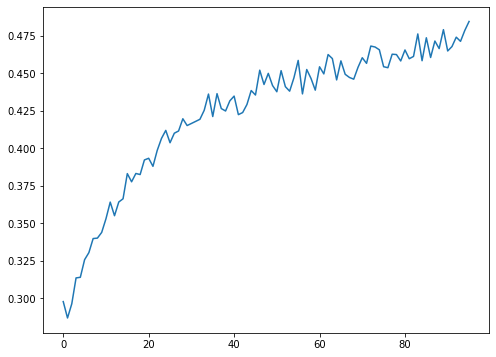

In [52]:
plt.plot(best_ada.estimator_errors_);

In [53]:
best_ada.feature_importances_

array([0.08574009, 0.09978206, 0.00960921, 0.11348423, 0.01153179,
       0.10310428, 0.11856401, 0.12007554, 0.04960036, 0.11074553,
       0.0424206 , 0.00693569, 0.12840662])

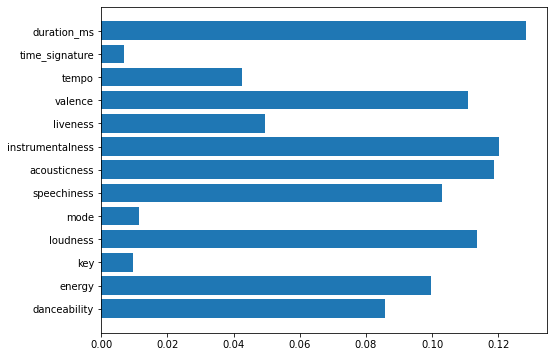

In [54]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_ada.feature_importances_);

## Gradient Boosting

### Implementación de sklearn

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
gb_clf = GradientBoostingClassifier()

In [9]:
cross_val_score(gb_clf, X_train,y_train, cv=10).mean()

0.734650308332371

### Implementación de lightgbm

In [44]:
import lightgbm as lgb

In [11]:
lgb_clf =lgb.LGBMClassifier()

In [108]:
%%time
cross_val_score(lgb_clf, X_train,y_train, cv=10).mean()

Wall time: 2.84 s


0.747594959064888

In [13]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
print("Precisión sobre el juego de pruebas: {:.2f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.2f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.74
Precisión sobre el juego de train: 0.78


In [15]:
param_range = [60,90,100,150,200,250,300]
train_score, test_score= validation_curve(
                                lgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [16]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 60 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 90 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 100 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 150 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 200 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 250 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 300 en test:',test_score[6].mean(),'en train:',train_score[6].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 60 en test: 0.7434250799654006 en train : 0.773958752139413
n_estimators 90 en test: 0.7464182710063174 en train: 0.7869039053533449
n_estimators 100 en test: 0.7471858419834135 en train: 0.790696624800657
n_estimators 150 en test: 0.7473393208346477 en train: 0.8083682783525724
n_estimators 200 en test: 0.747339304471599 en train: 0.8250102136417095
n_estimators 250 en test: 0.7477486130434509 en train: 0.8395543328749406
n_estimators 300 en test: 0.7475951407374362 en train: 0.8536571175752881


In [54]:
boosting_type = ['gbdt','dart', 'goss']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(10, 110, num = 11)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [float(x) for x in np.linspace(0.005, 1., num = 10)]
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# Proporción de submuestras de columnas al construir cada árbol
colsample_bytree = list(np.linspace(0.6, 1, 10))
# reg_alpha
reg_alpha = [float(x) for x in np.linspace(0.0, 1., num = 10)]
# reg_lambda
reg_lambda = [float(x) for x in np.linspace(0.0, 1., num = 10)]
# Creacion de cuadrícula aleatoria
param_grid = {'num_leaves': num_leaves,
             'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators,
             'subsample_for_bin': subsample_for_bin,
             'min_split_gain':min_split_gain,
             'min_child_samples':min_child_samples,
             'colsample_bytree':colsample_bytree,
             'reg_alpha':reg_alpha,
             'reg_lambda':reg_lambda}
print(param_grid)

{'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.11555555555555556, 0.22611111111111112, 0.33666666666666667, 0.44722222222222224, 0.5577777777777778, 0.6683333333333333, 0.778888888888889, 0.8894444444444445, 1.0], 'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'colsample_bytree': [0.6, 0.6444444444444444, 0.6888888888888889, 0.7333333333333333, 0.7777777777777778, 0.8222222222222222, 0.8666666666666667, 0.9111111111111111, 0.9555555555555555, 1.0], 'reg_alpha': [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.777777777777777

In [45]:
boosting_type = ['gbdt','dart', 'goss']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(10, 110, num = 11)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [float(x) for x in np.linspace(0.005, 1., num = 10)]
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [float(x) for x in np.linspace(0.0, 1., num = 10)]
# reg_lambda
reg_lambda = [float(x) for x in np.linspace(0.0, 1., num = 10)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
             'num_leaves': num_leaves,
             'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators,
             'subsample_for_bin': subsample_for_bin,
             'min_split_gain':min_split_gain,
             'min_child_samples':min_child_samples,
             'reg_alpha':reg_alpha,
             'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart', 'goss'], 'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.11555555555555556, 0.22611111111111112, 0.33666666666666667, 0.44722222222222224, 0.5577777777777778, 0.6683333333333333, 0.778888888888889, 0.8894444444444445, 1.0], 'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0], 'reg_lambda': [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 

In [46]:
lgb_clf = lgb.LGBMClassifier(random_state=42)

In [89]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ligth_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 40000, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [90]:
ligth_gbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                                       0.2222222222222222,
                                                  

In [94]:
ligth_gbm_random.best_params_

{'subsample_for_bin': 40000,
 'reg_lambda': 0.3333333333333333,
 'reg_alpha': 1.0,
 'num_leaves': 60,
 'n_estimators': 136,
 'min_split_gain': 0.8,
 'min_child_samples': 40,
 'max_depth': 50,
 'learning_rate': 0.11555555555555556}

In [91]:
ligth_gbm_random.best_score_

0.7512280582562495

In [92]:
best_light_gbm = ligth_gbm_random.best_estimator_

In [93]:
print("Precisión sobre el juego de pruebas: {:.2f}"
      .format(best_light_gbm.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.2f}"
      .format(best_light_gbm.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.75
Precisión sobre el juego de train: 0.81


In [95]:
filename = 'finalized_light_gbm_model.pkl'
joblib.dump(best_light_gbm, filename)

['finalized_light_gbm_model.pkl']

In [96]:
best_light_gbm = joblib.load('finalized_light_gbm_model.pkl') 

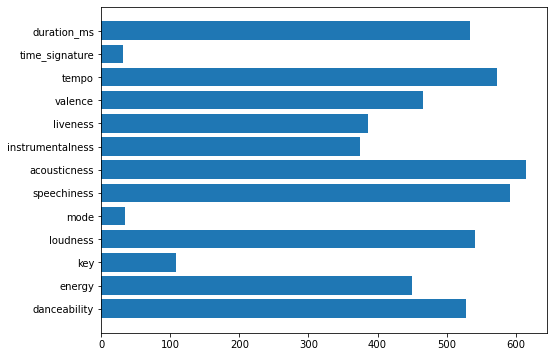

In [101]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_light_gbm.feature_importances_);

In [123]:
best_light_gbm.predict_proba(find_song())

Artista: 

 drake


Titulo: 

Canción elegida: POPSTAR (feat. Drake) de DJ Khaled


array([[0.2944884, 0.7055116]])

### Implementación de xgboost

In [1]:
import xgboost as xgb

In [4]:
xgb_clf = xgb.XGBClassifier()

In [107]:
%%time
cross_val_score(xgb_clf, X_train,y_train, cv=10).mean()

Wall time: 19.4 s


0.7438599295696648

In [38]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(xgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(xgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7407
Precisión sobre el juego de train: 0.8305


In [40]:
param_range = [60,90,100,150,200,250,300]
train_score, test_score= validation_curve(
                                xgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [41]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 60 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 90 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 100 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 150 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 200 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 250 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 300 en test:',test_score[6].mean(),'en train:',train_score[6].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 60 en test: 0.7453438732311422 en train : 0.8121290184713172
n_estimators 90 en test: 0.7432204862227548 en train: 0.8382047783748611
n_estimators 100 en test: 0.7426064202777705 en train: 0.8461036187391698
n_estimators 150 en test: 0.7407388335365134 en train: 0.8793491398532345
n_estimators 200 en test: 0.7363129986782256 en train: 0.9057702938495813
n_estimators 250 en test: 0.7359036671981057 en train: 0.9281109267134047
n_estimators 300 en test: 0.7341639085929994 en train: 0.9455523472620386


In [11]:
xgb_clf = xgb.XGBClassifier(learning_rate= 0.1,
                             max_depth=5,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)

In [12]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(xgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(xgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7442
Precisión sobre el juego de train: 0.7693


[0.7, 0.8, 0.9, 1.0]

In [14]:
booster = ['gbtree', 'gblinear', 'dart']
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(9, 12, num = 4)]
max_depth.append(None)
#Learning rate
learning_rate = [float(x) for x in np.linspace(0.005, 1., num = 10)]
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Minimum loss reduction required to make a further partition on a leaf node of the tree.
gamma 
# Minimum sum of instance weight(hessian) needed in a child.
min_child_weight = range(5,8)
# Subsample ratio of the training instance.
subsample = [i/10. for i in range(7,11)]
# Subsample ratio of columns when constructing each tree.
colsample_bytree = [i/10. for i in range(7,11)]
# Subsample ratio of columns for each level.
colsample_bylevel 
# Subsample ratio of columns for each split.
colsample_bynode 
# L1 regularization term on weights
reg_alpha 
# L2 regularization term on weights
reg_lambda 
# Balancing of positive and negative weights.
scale_pos_weight 
#The initial prediction score of all instances, global bias.
base_score
# Creacion de cuadrícula aleatoria
param_grid = {'booster': booster,
             'max_depth': max_depth,
             'learning_rate':learning_rate,
             'n_estimators':n_estimators,
             'gamma':gamma,
             'min_child_weight':min_child_weight,
             'subsample':subsample,
             'colsample_bytree':colsample_bytree,
             'colsample_bylevel':colsample_bylevel,
             'colsample_bynode':colsample_bynode,
             'reg_alpha':reg_alpha,
             'reg_lambda':reg_lambda,
             'scale_pos_weight':scale_pos_weight,
             'base_score':base_score}
print(param_grid)

NameError: name 'gamma' is not defined

In [18]:
booster = ['gbtree', 'gblinear', 'dart']
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(9, 12, num = 4)]
max_depth.append(None)
#Learning rate
learning_rate = [float(x) for x in np.linspace(0.005, 1., num = 10)]
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Minimum sum of instance weight(hessian) needed in a child.
min_child_weight = range(5,8)
# Subsample ratio of the training instance.
subsample = [i/10. for i in range(7,11)]
# Subsample ratio of columns when constructing each tree.
colsample_bytree = [i/10. for i in range(7,11)]
# Creacion de cuadrícula aleatoria
param_grid = {'booster': booster,
             'max_depth': max_depth,
             'learning_rate':learning_rate,
             'n_estimators':n_estimators,
             'min_child_weight':min_child_weight,
             'subsample':subsample,
             'colsample_bytree':colsample_bytree}
print(param_grid)

{'booster': ['gbtree', 'gblinear', 'dart'], 'max_depth': [9, 10, 11, 12, None], 'learning_rate': [0.005, 0.11555555555555556, 0.22611111111111112, 0.33666666666666667, 0.44722222222222224, 0.5577777777777778, 0.6683333333333333, 0.778888888888889, 0.8894444444444445, 1.0], 'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'min_child_weight': range(5, 8), 'subsample': [0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.7, 0.8, 0.9, 1.0]}


In [19]:
xgb_clf = xgb.XGBClassifier(random_state=42)

In [20]:
xgb_clf_grid = GridSearchCV(estimator = xgb_clf, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)

In [21]:
xgb_clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72000 candidates, totalling 360000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.4s


KeyboardInterrupt: 

In [24]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_grid, n_iter = 2400, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 75.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 101.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 126.5min


## Support Vector classifier

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import normalize

In [32]:
X_Normalized = normalize(df_songs.loc[:,"danceability":"duration_ms"])
y = df_songs.iloc[:,-1]
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(X_Normalized, y, random_state=0)

In [33]:
linerar_svc = SVC()

In [34]:
%%time
cross_val_score(linerar_svc, X_train_N,y_train_N, cv=10).mean()

KeyboardInterrupt: 

In [41]:
linerar_svc.fit(X_train_N,y_train_N)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
print("Precisión sobre datos de pruebas: {:.2f}"
      .format(linerar_svc.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.2f}"
      .format(linerar_svc.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.50
Precisión sobre datos de train: 0.50


In [118]:
linerar_svc.predict(find_song())

Artista: 

 taylor swift


Titulo: 

 the 1


array([0], dtype=int64)